<a href="https://colab.research.google.com/github/waveology/kitchen/blob/main/introduccion_cartopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Cartopy


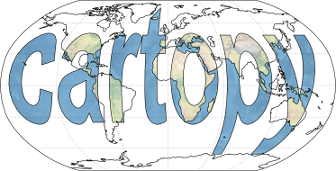

* [Web del proyecto](https://scitools.org.uk/cartopy/docs/latest/)
* [Referencia de la API](https://scitools.org.uk/cartopy/docs/latest/reference/index.html)
* [Galería](https://scitools.org.uk/cartopy/docs/latest/gallery/index.html)

* **¿Qué es Cartopy?** Una extensión de Python para dibujar mapas y datos sobre ellos.

* **¿Cómo se usa Cartopy?** Partiendo de una proyección cartográfica añadimos elementos geográficos y superponemos los datos.

* **¿Cuándo usar Cartopy?** Cuando se requiera la presentación de datos en un contexto geográfico

* **¿Por qué Cartopy?** Porque es fácil de usar en relación con otras alternativas





## Instalación
---

Como suele ser habitual hay múltiples formas de instalar ***Cartopy***. En este notebook utilizaremos la que se basa en el sistema de gestión de paquetes ***pip***.

Por alguna razón, <u>en la plataforma Colab</u>, la instalación de ***Cartopy*** requiere de una línea adicional para forzar la instalación del módulo ***shapely***. Es posible que eso no sea necesario en un futuro.

In [1]:
# Esta línea parece ser necesaria en Colab
# ----------------------------------------------
!pip -q install --no-binary shapely shapely --force

# Instalación de Cartopy
# ------------------------
!pip -q install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.6 MB/s eta 0:00:00


##Descarga de datos
---

* Descargamos un fichero de datos del reanálisis ERA del ECMWF.
En este caso se trata de campos de viento y temperatura en los niveles de presión de 1000, 850, 500 y 300 hPa, correspondientes a las 12:00 UTC del día 15 de cada mes de 2020.

* Estos datos están disponibles gratuitamente en el portal de C3S de Copernicus: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form

* También descargamos algunos datos geográficos que se encuentran libremente disponibles en https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE

In [68]:
ifile = 'era5_pl_vt_2020_europa_025.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/yWpdSTonSFuJz6c/download -O {ifile} && unrar -o+ e {ifile} && rm -f {ifile}
!mv era5_pl_vt_2020_europa_025.nc era5_2000.nc

ifile = 'pueblos_canarias.rar'
!wget -q --no-check-certificate https://owncloud.aemet.es/index.php/s/QFgC7D4VQbYQ4aF/download -O {ifile} && unrar -o+ x {ifile} && rm -f {ifile}


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from pueblos_canarias.rar

Creating    pueblos_canarias                                          OK
Extracting  pueblos_canarias/recintos_municipales_inspire_canarias_regcan95.cpg       0%  OK 
Extracting  pueblos_canarias/recintos_municipales_inspire_canarias_regcan95.dbf       0%  OK 
Extracting  pueblos_canarias/recintos_municipales_inspire_canarias_regcan95.prj       0%  OK 
Extracting  pueblos_canarias/recintos_municipales_inspire_canarias_regcan95.shp       1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 52% 53% 54% 55%

##Importa extensiones Python

In [3]:
# Extensión base de Cartopy
# --------------------------
import cartopy.crs as ccrs

# Extensión gráfica genérica de Python
# ------------------------------------
import matplotlib.pyplot as plt

# Extensión de cálculo con arrays
# -------------------------------
import numpy as np

##Gráficos de mapas y proyecciones cartográfcas

No hay un procedimiento único para construir un mapa en Cartopy. El que se propone aquí es muy versátil y facilita la posibilidad de escalar la complejidad del gráfico.

* Empezamos por crear una figura contenedora a la que asignamos las dimensiones del gráfico.

* Añadimos uno o más gráficos (ejes) a la figura.

* A cada gráfico de la figura le asignamos una proyección cartográfica de entre las de [esta lista](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html?highlight=projections).

###Ejemplo: un mapa simple

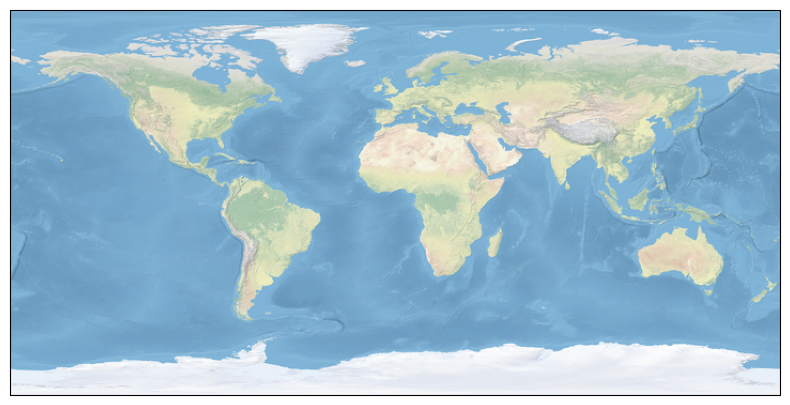

In [4]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un gráfico (eje) a la figura
# Los índices corresponden respectivamente a la fila, la columna y al ordinal del gráfico actual
# En este caso de gráfico único: solo hay una fila y una columna
# La proyección cartográfica elegida en este caso es la equirectangular (conocida como 'Plate Carrée')
# En la Plate Carrée, los meridianos y los paralelos están igualmente equiespaciados.
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

# Añadimos un fondo genérico con océanos y continentes
# -----------------------------------------------------
ax.stock_img()

plt.show()

###Ejemplo: múltiples mapas en la misma figura

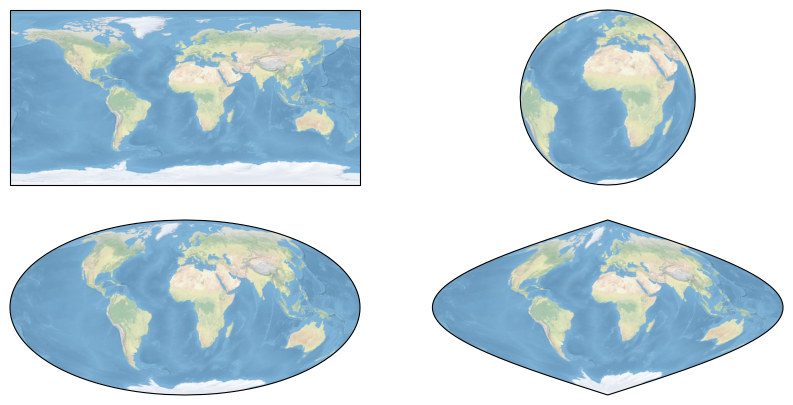

In [5]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos gráficos (ejes) a la figura
# Los índices corresponden respectivamente a la fila, la columna y la posición del gráfico
# En este caso tenemos 4 gráficos dispuestos en 2 filas y dos columnas
# Elegimos diferentes proyecciones en cada uno
# -----------------------------------------------------------------------------------------------
ax1 = fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2,2,2,projection=ccrs.Orthographic())
ax3 = fig.add_subplot(2,2,3,projection=ccrs.Mollweide())
ax4 = fig.add_subplot(2,2,4,projection=ccrs.Sinusoidal())

# Asignamos propiedades comunes a los 4 mapas
# -----------------------------------------------
for ax in (ax1,ax2,ax3,ax4) :

   # Se asegura de que el mapa llega a los límites de la proyección
   # ---------------------------------------------------------------
   ax.set_global()

   # Añadimos el fondo genérico con océanos y continentes
   # -----------------------------------------------------
   ax.stock_img()


plt.show()

##Paralelos y meridianos

Las líneas geográficas se añaden con la función ***gridlines***, que admite algunos procedimientos para refinar el resultado.

###Ejemplo: líneas geográficas en diferentes proyecciones

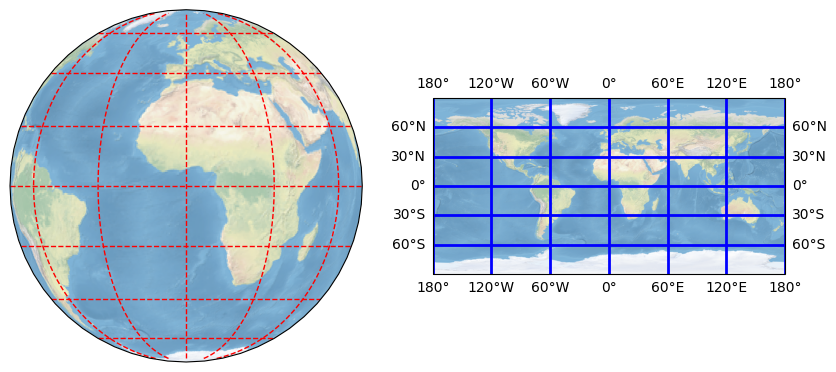

In [7]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos dos gráficos a la figura
# ----------------------------------------------------------
ax1 = fig.add_subplot(1,2,1, projection=ccrs.Orthographic())
ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

# Añadimos paralelos y meridianos
# ----------------------------------
ax1.gridlines(draw_labels=False,   # etiquetas
             color='red',          # color
             ls='--',              # estilo
             lw=1                  # grosor
             )

ax2.gridlines(draw_labels=True,    # etiquetas
             dms=True,             # grados,minutos y segundos o fracciones de grado
             x_inline=False,       # etiquetas dentro/fuera del gráfico
             y_inline=False,       #
             color='blue',         # color
             ls='-',               # estilo
             lw=2                  # grosor
             )

for ax in (ax1,ax2) :

   # Se asegura de que el mapa llega a los límites de la proyección
   # ---------------------------------------------------------------
   ax.set_global()

   # Añadimos el fondo genérico con océanos y continentes
   # -----------------------------------------------------
   ax.stock_img()


plt.show()

###Ejemplo: especificación detallada de líneas geográficas

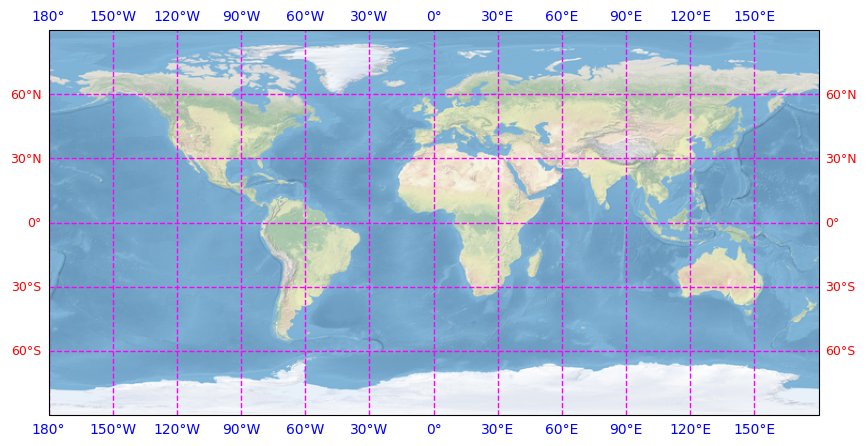

In [13]:
# Formato y posicionamiento de etiquetas
# ---------------------------------------
import matplotlib.ticker as mticker

# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[18, 5])

# Añadimos un gráfico a la figura
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())


# Añadimos paralelos y meridianos
# Generamos el objeto gl para el posterior refinamiento
# -------------------------------------------------------
gl = ax.gridlines(draw_labels=False,
             color='#ff00ff',
             ls='--',
             lw=1.0
             )

# Dónde dibujar paralelos y meridianos
# --------------------------------------------------
gl.xlocator = mticker.FixedLocator(range(-180,180,30))
gl.ylocator = mticker.FixedLocator(range(-90,90,30))

# Qué lados tienen etiquetas
# ------------------------------
gl.top_labels=True
gl.right_labels=True
gl.bottom_labels=True
gl.left_labels=True

# Tamaño y color de las etiquetas
# ---------------------------------
gl.xlabel_style = {'size': 10, 'color': 'blue'}
gl.ylabel_style = {'size':  9, 'color': 'red'}

# Nos aseguramos de que el mapa llega hasta el límite de la proyección
# --------------------------------------------------------------------
ax.set_global()

# Añadimos un fondo genérico con océanos y continentes
# -----------------------------------------------------
ax.stock_img()


plt.show()

## Océanos y continentes

* Cuando no se utiliza una imagen de fondo puede ser necesario configurar el aspecto que presentan mares, continentes y la línea de separación entre ambos.

* La configuración de estos elementos y otros como ríos, lagos y fronteras requiere del módulo [`cartopy.feature`](https://scitools.org.uk/cartopy/docs/latest/reference/feature.html)

* Cada elemento se añade secuencialmente al mapa como un *feature* independiente

* Puede resultar útil conocer algunos [nombres de colores](https://matplotlib.org/stable/gallery/color/named_colors.html) en `Matplotlib`


###Ejemplo: configuración de océanos, continentes y líneas de costa

In [14]:
# Permite representar océanos, continentes, líneas de costa, ríos, fronteras, etc
# --------------------------------------------------------------------------------
import cartopy.feature as cfeature


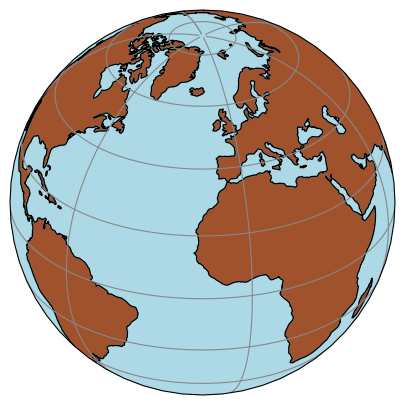

In [22]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica centrada en latitud=30N y longitud=15W
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.Orthographic(central_longitude=-15, central_latitude=30))

# ======================== GLOBAL =============================
ax.set_global()
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
ax.gridlines(color='#888888')
# =============================================================

# ================== CONTINENTES ==============================
ax.add_feature(cfeature.LAND, color='sienna')
# =============================================================

# ================== OCÉANOS ==================================
ax.add_feature(cfeature.OCEAN, color='lightblue')
# =============================================================

# ================== LINEA DE COSTA ===========================
ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=1)

# ¿Más resolución? Opciones: 10m / 50m / 110m
# ----------------------------------------------------------------------------
# ax.add_feature(cfeature.COASTLINE.with_scale("50m"), edgecolor='black', lw=1)
# ==============================================================================

plt.show()

##Zoom en un área

* Hasta ahora hemos visto mapas globales declarados con la función set_global()

* Para especificar un área de interés se usa la función `set_extent[oeste,este,sur,norte]`
* El área especificada activa automáticamente el uso de líneas costeras de mayor resolución a la que se usa por defecto para mapas globales (110 metros).
* Las líneas de costa por defecto pueden no ser suficiente en algunos casos
* `set_global()` y `set_extent()` son incompatibles

###Ejemplo: definir detalles en un área

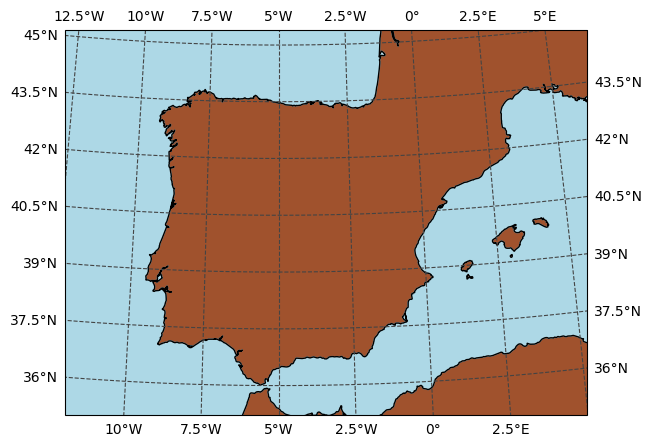

In [34]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.Orthographic(central_longitude=-5, central_latitude=40))

# ======================== ÁREA =============================
# Península y Baleares
ax.set_extent((-11.9,5,35,45))
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
gl = ax.gridlines(color='#444444', draw_labels=True, ls='--')

# =============================================================

# ================== CONTINENTES ==============================
ax.add_feature(cfeature.LAND, color='sienna')
# =============================================================

# ================== OCÉANOS ==================================
ax.add_feature(cfeature.OCEAN, color='lightblue')
# =============================================================

# ================== LINEA DE COSTA ===========================
# Aunque no se especifica la resolución, el área seleccionada
# ha activado automáticamente la necesidad de líneas de costa
# de 10 metros
# -------------------------------------------------------------
ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=1)
# =============================================================

plt.show()

###Ejemplo: resolución de líneas de costa en áreas pequeñas

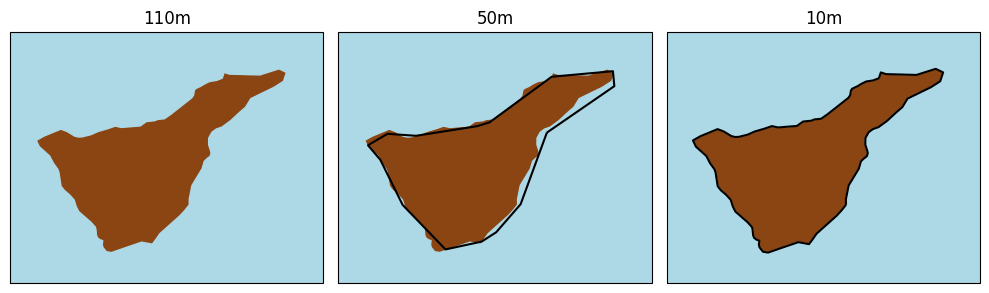

In [54]:
# Otra manera de hacer lo mismo, pero en una sola línea.
# Definimos la figura y tres gráficos
# -------------------------------------------------
fig, ax = plt.subplots(figsize=[10,5],
                        nrows=1,
                        ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        )

# Tres resoluciones espaciales para la línea de costa
# ----------------------------------------------------
resolucion = ['110m', '50m', '10m']

# Todos los mapas comparten las mismas propiedades salvo la resolución
# de la línea de costa
# --------------------------------------------------------------------
for i in range(3):

   # ======================== ÁREA ===============================
   # Tenerife
   # ---------------
   ax[i].set_extent((-17,-16,27.9,28.7))
   # =============================================================

   # ================== CONTINENTES ==============================
   ax[i].add_feature(cfeature.LAND, color='saddlebrown')
   # =============================================================

   # ================== OCÉANOS ==================================
   ax[i].add_feature(cfeature.OCEAN, color='lightblue')
   # =============================================================

   # ================== LINEA DE COSTA ===========================
   ax[i].add_feature(cfeature.COASTLINE.with_scale(resolucion[i]), edgecolor='black', lw=1.5)
   # =============================================================

   ax[i].set_title(resolucion[i])


plt.tight_layout()
plt.show()

###Ejemplo: añadir lagos y ríos

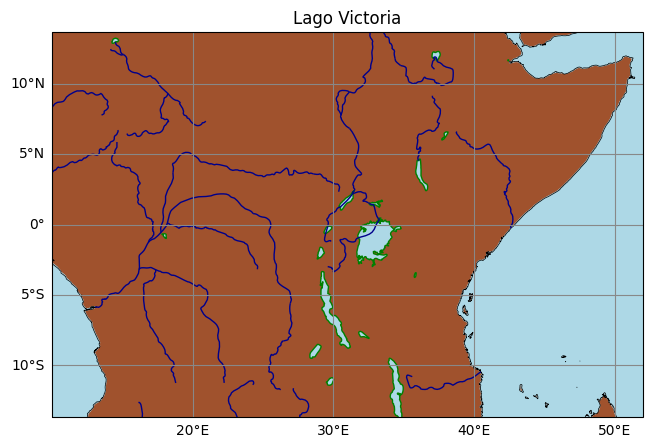

In [63]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

# ======================== ÁREA =============================
# África central
# ---------------
ax.set_extent((10,52,-13,13))
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
gl = ax.gridlines(color='#888888', draw_labels=True)
gl.top_labels=False
gl.right_labels=False
# =============================================================

# ================== CONTINENTES ==============================
ax.add_feature(cfeature.LAND, color='sienna')
# =============================================================

# ================== OCÉANOS ==================================
ax.add_feature(cfeature.OCEAN, color='lightblue')
# =============================================================

# ================== LINEA DE COSTA ===========================
# La resolución espacial puede ser de 10 m,  50 m o 110 m
# ---------------------------------------------------------
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), edgecolor='black', lw=0.5)
# =============================================================

# =================== LAGOS ===================================
ax.add_feature(cfeature.LAKES, alpha=1, facecolor='lightblue', edgecolor='green')
# =============================================================

# ============================ RÍOS ===========================
ax.add_feature(cfeature.RIVERS, color='darkblue')
# =============================================================

# Añadimos un título
# -------------------
ax.set_title('Lago Victoria')

plt.show()

##Límites administrativos

* Cartopy incluye algunas opciones para representar fronteras nacionales o divisiones interiores.

* Sin embargo, la oferta puede ser insuficiente para determinados propósitos (límites autonómicos o municipales por ejemplo)

* En esos casos será necesario recurrir a datos externos e incorporarlos al mapa con la función `shapely_feature`

* Hay una gran cantidad de datos geográficos disponibles libremente en la web del [Instituto Geográfico Nacional](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE)


###Ejemplo: fronteras y provincias

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

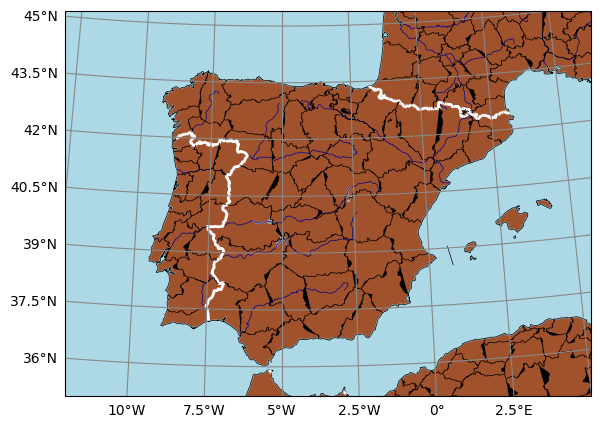

In [81]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.Orthographic(central_longitude=-5, central_latitude=40))

# ======================== ÁREA =============================
ax.set_extent((-12,5,35,45))
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
gl = ax.gridlines(color='#888888', draw_labels=True)
gl.top_labels=False
gl.right_labels=False
# =============================================================

# ================== CONTINENTES ==============================
ax.add_feature(cfeature.LAND, color='sienna')
# =============================================================

# ================== OCÉANOS ==================================
ax.add_feature(cfeature.OCEAN, color='lightblue')
# =============================================================

# ================== LINEA DE COSTA ===========================
# La resolución espacial puede ser de 10 m,  50 m o 110 m
# ---------------------------------------------------------
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), edgecolor='black', lw=0.5)
# =============================================================

# =================== LAGOS ===================================
ax.add_feature(cfeature.LAKES, alpha=0.5, color='lightblue')
# =============================================================

# ============================ RÍOS ===========================
ax.add_feature(cfeature.RIVERS, color='darkblue', lw=0.5)
# =============================================================

# ================== FRONTERAS NACIONALES =====================
ax.add_feature(cfeature.BORDERS, color='white', lw=2)
# =============================================================


# ================== DIVISIONES INTERNAS =====================
# Crear un 'feature' con las provincias
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
# ---------------------------------------------------------------------------------------------
provincias = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m')

ax.add_feature(provincias,color='black', lw=0.5)
# =============================================================


plt.show()

###Ejemplo: uso de datos externos

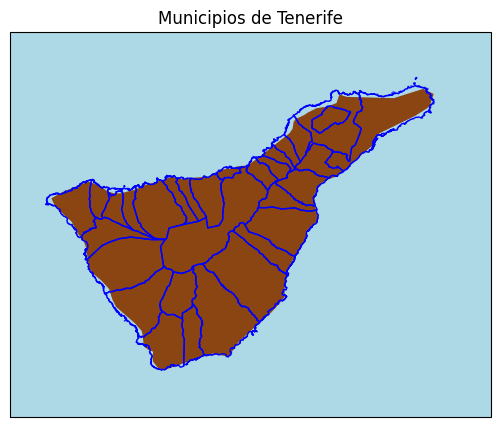

In [80]:
# Importamos módulos de Cartopy que permiten leer
# y representar el formato SHP
# -----------------------------------------------
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Hemos descargado los límites municipales de Canarias
# de la web del IGN y disponemos de un fichero SHP
# ---------------------------------------------------

pueblos = ShapelyFeature(Reader('pueblos_canarias/recintos_municipales_inspire_canarias_regcan95.shp').geometries(),
                                ccrs.PlateCarree(),
                                facecolor='none')

# Definimos la figura y el gráfico
# -------------------------------------------------
fig, ax = plt.subplots(figsize=[10,5], nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()})

# ======================== ÁREA ===============================
# Tenerife
# ---------------
ax.set_extent((-17,-16,27.9,28.7))
# =============================================================

# ================== CONTINENTES ==============================
ax.add_feature(cfeature.LAND, color='saddlebrown')
# =============================================================

# ================== OCÉANOS ==================================
ax.add_feature(cfeature.OCEAN, color='lightblue')
# =============================================================

# ======================== PUEBLOS ===========================
ax.add_feature(pueblos, edgecolor='blue')
# =============================================================

ax.set_title('Municipios de Tenerife')

plt.show()

##Datos con **xarray**

* Teniendo una idea de como se construyen mapas con `Cartopy` podemos empezar a representar datos espaciales en ellos.

* En este bloque vamos a usar xarray, una extensión de `Python` que permite el acceso a datos de diverso formato, su manipulación en operaciones sencillas y la representación en `Cartopy`.

* Existe una diferencia de tratamiento entre datos escalares (temperaturas, concentraciones de contaminantes, etc) y datos vectoriales (viento, corrientes marinas, etc)

* Por lo general, una vez establecida una proyección cartográfica con la función `projection` los datos equiespaciadas en latitud y longitud han de transformarse a la proyección mediante la función `transform`

* Usaremos datos del reanálisis ERA5, libremente disponibles en la web del [C3S de Copernicus](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)

* Puede ser interesante familiarizarse con los nombres de algunos [mapas de color de `Matplotlib`](https://matplotlib.org/stable/tutorials/colors/colormaps.html) porque algunos se ajustan mejor que otros al tipo de datos que queramos representar

* Estos mapas de color se especifican habitualmente mediante el argumento `cmap`

* Como siempre, tengamos presente que hay más de una forma de llegar al mismo resultado.

###Ejemplo: mapa simple de temperaturas

In [82]:
# Importamos xarray
# -------------------
import xarray as xr

In [84]:
# Abrimos el fichero de datos meteorológicos (ERA5)
# ------------------------------------------------------------
ds = xr.open_dataset('era5_2000.nc')


# ¿Qué contienen los datos?
# 3 campos             : temperatura a 2 metros (K) y componentes zonal/meridional del viento a 10 metros (m/s)
# 4 niveles verticales : 1000, 850, 500 y 300 hPa
# 12 tiempos           : mediodía del día 15 de cada mes del año 2020
# ------------------------------------------------------------------------------------------
print(ds.coords)
print(ds.data_vars)

Coordinates:
  * longitude  (longitude) float32 -60.0 -59.75 -59.5 -59.25 ... 59.5 59.75 60.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... -29.5 -29.75 -30.0
  * level      (level) int32 300 500 850 1000
  * time       (time) datetime64[ns] 2020-01-15T12:00:00 ... 2020-12-15T12:00:00
Data variables:
    t        (time, level, latitude, longitude) float32 ...
    u        (time, level, latitude, longitude) float32 ...
    v        (time, level, latitude, longitude) float32 ...


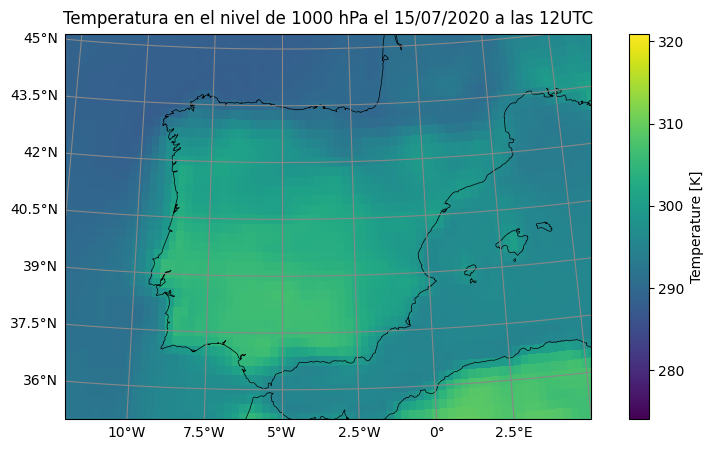

In [105]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica centrada en latitud=40N y longitud=5W
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1, projection=ccrs.Orthographic(central_longitude=-5, central_latitude=40))

# ======================== ÁREA ===============================
ax.set_extent((-12,5,35,45))
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
gl = ax.gridlines(color='#888888', draw_labels=True)
gl.top_labels=False
gl.right_labels=False
# =============================================================

# ================== LINEA DE COSTA ===========================
ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=0.5)
# =============================================================

# ====================  DATOS =================================

# Seleccionamos una fecha y un nivel vertical
# Indicamos que nuestros datos están equiespaciados en
# longitud/latitud mediante el parámetro transform
# ---------------------------------------------------
ds.t.sel(time='2020-07-15T12:00:00',level=1000).plot(ax=ax, transform=ccrs.PlateCarree())

# # Podríamos haber pasado las temperaturas de Kelvin a °C antes de dibujar
# # Y también refinar algunos aspectos en relación con el color y las etiquetas
# # -------------------------------------------------------------------------
# (ds.t.sel(time='2020-07-15T12:00:00',level=1000)-273.15).plot(ax=ax,
#                                                      cmap='jet',
#                                                      vmin = 10,
#                                                      vmax = 40,
#                                                      transform=ccrs.PlateCarree(),
#                                                      cbar_kwargs={'label': "Temperatura (°C)"})

# Título para el gráfico
# ---------------------------------------------------------------
ax.set_title('Temperatura en el nivel de 1000 hPa el 15/07/2020 a las 12UTC')


plt.show()

### Ejemplo: temperatura en múltiples mapas

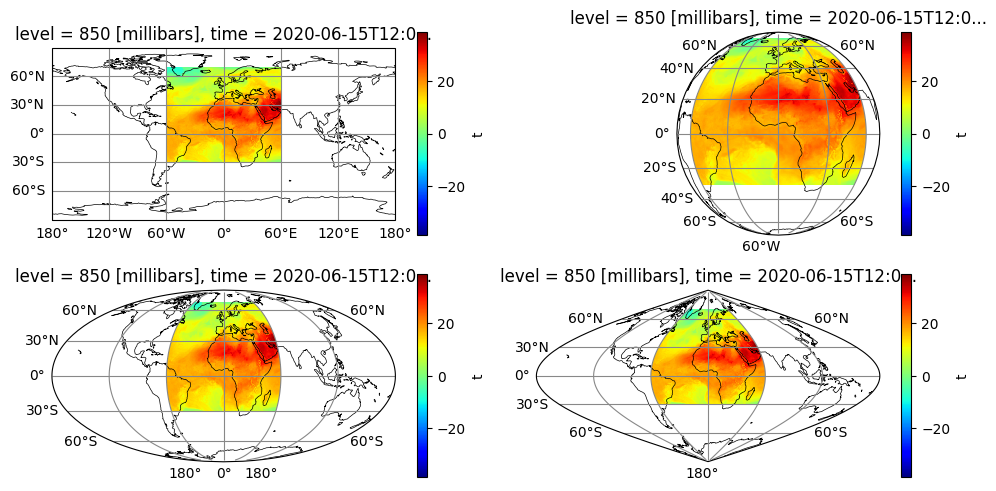

In [107]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos 4 mapas con proyecciones ortográficas distintas
# ----------------------------------------------------------------------------------------------
ax1 = fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2,2,2,projection=ccrs.Orthographic())
ax3 = fig.add_subplot(2,2,3,projection=ccrs.Mollweide())
ax4 = fig.add_subplot(2,2,4,projection=ccrs.Sinusoidal())

# Pasamos a grados centígrados y seleccionamos un tiempo y un nivel
# -----------------------------------------------------------------
temp = (ds.t - 273.15).sel(time='2020-06-15T12:00:00',level=850)

# Los cuatro mapas comparten las mismas propiedades
# ---------------------------------------------------
for ax in (ax1,ax2,ax3,ax4) :

   # Dibuja el mapa de temperaturas
   # Nótese el parámetro transform
   # -----------------------------------
   temp.plot(ax=ax, transform=ccrs.PlateCarree(),cmap='jet')


  # #  ¿Qué ocurre si no incluimos el parámetro transform?
  # #  Pues que solo funciona correctamente el único caso en
  # #  que no se precisa de transformación (PlateCarrée)
  # #  ----------------------------------------------------
  #  temp.plot(ax=ax,cmap='jet')


   # ======================== ÁREA ===============================
   #ax.set_extent((-12,5,35,45))
   ax.set_global()
   # =============================================================

   # ================== PARALELOS Y MERIDIANOS ===================
   gl = ax.gridlines(color='#888888', draw_labels=True, x_inline=False, y_inline=False)
   gl.top_labels=False
   gl.right_labels=False
   # =============================================================

   # ================== LINEA DE COSTA ===========================
   ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=0.5)
   # =============================================================

# Itenta ajustar la disposición de los gráficos
# ------------------------------------------------
plt.tight_layout()

plt.show()

* `xarray` proporciona un método llamado faceting que permite generar múltiples mapas de acuerdo a las dimensiones de los datos.

* Por ejemplo, si tenemos datos espaciales en diferentes tiempos y niveles, fijando el tiempo obtenemos mapas de todos los niveles. Y fijando el nivel generamos mapas de todos los tiempos

* Esta técnica simplifica algunos aspectos de la representación como por ejemplo el uso de una única escala de color



###Ejemplo: "`faceting`" con los niveles verticales

(2, 2)


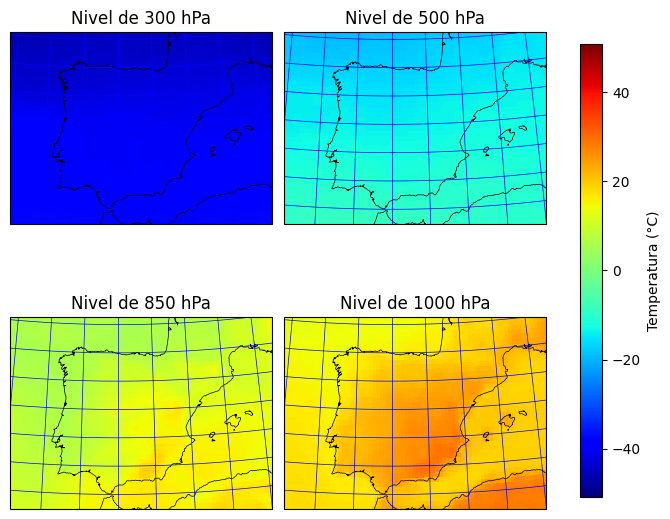

In [114]:
# Seleccionamos un día
# La variable temp contiene datos espaciales en 4 niveles verticales
# --------------------------------------------------------------------
temp = (ds.t - 273.15).sel(time='2020-06-15T12:00:00')

# Creamos un objeto FacetGrid
# ----------------------------
fg = temp.plot(col='level',                    # dimensión que define los subconjuntos
              col_wrap=2,                      # número de columnas
              cmap='jet',                      # mapa de color
              size=3,                          # tamaño
              transform=ccrs.PlateCarree(),    # transformación datos --> proyección
              subplot_kws={                    # algunas propiedades de los mapas

                  'projection':  ccrs.Orthographic(central_longitude=-5, central_latitude=40),
                  'extent'    :  (-12,5,35,45)},

              cbar_kwargs={                    # algunas propiedades de la escala de color

                  'label'  : 'Temperatura (°C)',
                  'shrink' : 0.80}
)

# El objeto FaceGrid contiene el array de ejes de la figura
# ------------------------------------------------------------
print(fg.axs.shape)

# Lo usamos para asignar propiedades específicas a cada mapa
# -----------------------------------------------------------
fg.axs[0,0].set_title('Nivel de 300 hPa')
fg.axs[0,1].set_title('Nivel de 500 hPa')
fg.axs[1,0].set_title('Nivel de 850 hPa')
fg.axs[1,1].set_title('Nivel de 1000 hPa')

# Y también para asignar propiedades generales
# -------------------------------------------
for ax in fg.axs.flatten() :

  # Línea de costas
  # -----------------
  ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=0.5)

  # Paralelos y meridianos
  # -----------------------
  ax.gridlines(color='blue', lw=0.5)


plt.show()

###Faceting con el tiempo

In [ ]:
# Seleccionamos un nivel vertical
# --------------------------------------------
temp = (ds.t - 273.15).sel(level=1000)

# Creamos un objeto FacetGrid
# ----------------------------
fg = temp.plot(col='time',                    # dimensión que define los subconjuntos (el tiempo)
              col_wrap=4,                     # número máximo de gráficos antes de saltar a la siguiente fila
              cmap='jet',                     # paleta de colores
              vmin=-5,                       # rango de valores a representar
              vmax=40,
              size=3,
              transform=ccrs.PlateCarree(),   # transformación a aplicar a los datos
              subplot_kws={                   # diccionario con propiedades de los mapas
                  'projection':  ccrs.Orthographic(central_longitude=-5, central_latitude=40),
                  'extent'    :  (-12,5,35,45)},
              cbar_kwargs={'label'  : 'Temperatura (°C)',
                           'shrink' : 0.80}
)

# El objeto FaceGrid contiene el array de ejes de la figura
# ------------------------------------------------------------
print(fg.axs.shape)

# # Lo usamos para asignar propiedades a cada mapa
# # -----------------------------------------------
# fg.axs[0,0].set_title('Nivel de 300 hPa')
# fg.axs[0,1].set_title('Nivel de 500 hPa')
# fg.axs[1,0].set_title('Nivel de 850 hPa')
# fg.axs[1,1].set_title('Nivel de 1000 hPa')

# Y para asignar propiedades generales
# --------------------------------------
for ax in fg.axs.flatten() :

  # Línea de costas
  # -----------------
  ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=0.5)

  # Paralelos y meridianos
  # -----------------------
  ax.gridlines(color='blue', lw=0.5)

plt.show()

## Campos vectoriales

In [ ]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax1 = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(central_longitude=0, central_latitude=30))
ax2 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

# Seleccionamos un nivel y una fecha
# Remuestreamos las longitudes y las latitudes para
# aligerar el dibujo de vectores: tomamos un punto de cada 10
# ---------------------------------------------------------------------------------
muestreo = 15
viento = ds.sel(level=500, time='2020-01-15T12:00:00').thin({'longitude':muestreo,'latitude':muestreo})

# Dibujamos los datos de viento en la proyección cartográfica
# ------------------------------------------------------------
q = viento.plot.quiver('longitude','latitude','u','v',transform=ccrs.PlateCarree(),add_guide=False,ax=ax1)
ax1.quiverkey(q, 0.83, 1.035, 40, '40m/s', labelpos='E',coordinates='axes', color='black')
ax1.set_global()
ax1.gridlines(draw_labels=False)
ax1.set_title('Viento en 500 hPa')
ax1.stock_img()

# Dibujamos los datos de viento en la proyección equidistante
# ------------------------------------------------------------
q2 = viento.plot.quiver('longitude','latitude','u','v',transform=ccrs.PlateCarree(),add_guide=False,ax=ax2)
ax2.quiverkey(q2, 0.84, 1.05, 40, '40m/s', labelpos='E',coordinates='axes', color='black')
ax2.set_extent((-60,60,-15,60),transform=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax2.set_title('Viento en 500 hPa')
ax2.stock_img()

###Módulo del vector como background

In [ ]:
# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax1 = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(central_longitude=0, central_latitude=20))
ax2 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())

# Seleccionamos un nivel y una fecha
# Remuestreamos las longitudes y las latitudes para
# aligerar el dibujo de vectores: tomamos un punto de cada 10
# ---------------------------------------------------------------------------------
viento = ds[['u','v']].sel(level=300,time='2020-01-15T12:00:00')
viento = viento.assign(velocidad=np.sqrt(viento.u**2 + viento.v**2))

muestreo = 15
viento_muestreado = viento.thin({'longitude':muestreo,'latitude':muestreo})

# Para ax1 y ax2
# --------------
for ax in (ax1,ax2):
   viento.velocidad.plot(transform=ccrs.PlateCarree(), ax=ax,cmap='Blues', cbar_kwargs={'shrink':0.65})
   viento_muestreado.plot.quiver('longitude','latitude','u','v',transform=ccrs.PlateCarree(),add_guide = False,ax=ax)
   ax.gridlines(draw_labels=False)
   ax.add_feature(cfeature.COASTLINE, edgecolor='black', lw=1)

# Específico para ax1
# --------------------
ax1.set_global()

# Específico para ax2
# -------------------
gl=ax2.gridlines()
gl.bottom_labels=True
gl.left_labels=True


plt.tight_layout()

In [ ]:
from owslib.wmts import WebMapTileService


# Definimos la figura que actúa como contenedor y le asignamos las dimensiones
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=[10, 5])

# Añadimos un mapa con proyección ortográfica
# ----------------------------------------------------------------------------------------------
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())


# ======================== ÁREA =============================
ax.set_extent((-8,-4,41,44))
# =============================================================

# ================== PARALELOS Y MERIDIANOS ===================
gl = ax.gridlines(color='#888888', draw_labels=True)
gl.top_labels=False
gl.right_labels=False
gl.xlocator = mticker.FixedLocator(range(-180,180,1))
gl.ylocator = mticker.FixedLocator(range(-90,90,1))

# =============================================================

# Datos del instrumento MODIS a bordo de Aqua/Terra
# Adquisición vía servicio WMT
# ------------------------------------------------------
url    =   'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
wmts   =   WebMapTileService(url)
layer  =   'MODIS_Terra_SurfaceReflectance_Bands143'

# ================ Datos de satélite ============================
ax.add_wmts(wmts, layer,wmts_kwargs={'time': '2021-01-11'})
# ================================================================

# Título
# ------------------------------------------------------
ax.set_title('Picos de Europa el 12 de enero de 2021')


plt.show()

In [ ]:
# !pip install owslib
# from owslib.wmts import WebMapTileService




In [ ]:
shaded_srtm